In [1]:
import pandas as pd
import numpy as np

# Load dataset (your notebook is inside the same "data" folder as the CSV)
df = pd.read_csv("netflix_titles.csv")

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Dataset shape: (8807, 12)
Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [2]:
import pandas as pd
import numpy as np

# 1) Start from the full dataset already loaded as df
df2 = df.copy()

# 2) Keep Movies only (TV Shows have duration in seasons, not minutes)
movies = df2[df2["type"] == "Movie"].copy()

# 3) Convert duration like "90 min" -> 90
movies["duration_minutes"] = (
    movies["duration"]
    .astype(str)
    .str.replace(" min", "", regex=False)
)

# Convert to numeric (bad values become NaN)
movies["duration_minutes"] = pd.to_numeric(movies["duration_minutes"], errors="coerce")

print("Movies shape (before cleaning):", movies.shape)

# 4) Remove rows where target is missing
movies_clean = movies.dropna(subset=["duration_minutes"]).copy()

print("Movies shape (after removing missing duration_minutes):", movies_clean.shape)
print("Target (duration_minutes) summary:")
print(movies_clean["duration_minutes"].describe())


Movies shape (before cleaning): (6131, 13)
Movies shape (after removing missing duration_minutes): (6128, 13)
Target (duration_minutes) summary:
count    6128.000000
mean       99.577187
std        28.290593
min         3.000000
25%        87.000000
50%        98.000000
75%       114.000000
max       312.000000
Name: duration_minutes, dtype: float64


In [3]:
# Select features (X) and target (y)
features = ["release_year", "rating", "country"]
target = "duration_minutes"

data = movies_clean[features + [target]].copy()

print("Selected columns:", data.columns.tolist())
print("Missing values per column:\n", data.isna().sum())

# Fill missing values
# release_year is usually complete, but just in case:
data["release_year"] = data["release_year"].fillna(data["release_year"].median())

# Fill missing categories with a label
data["rating"] = data["rating"].fillna("Unknown")
data["country"] = data["country"].fillna("Unknown")

print("\nMissing after fill:\n", data.isna().sum())
print("\nCleaned ML dataset shape:", data.shape)


Selected columns: ['release_year', 'rating', 'country', 'duration_minutes']
Missing values per column:
 release_year          0
rating                2
country             440
duration_minutes      0
dtype: int64

Missing after fill:
 release_year        0
rating              0
country             0
duration_minutes    0
dtype: int64

Cleaned ML dataset shape: (6128, 4)


In [4]:
from sklearn.model_selection import train_test_split

# Split X and y
X = data[["release_year", "rating", "country"]].copy()
y = data["duration_minutes"].copy()

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=["rating", "country"], drop_first=True)

print("X shape before encoding:", X.shape)
print("X shape after encoding:", X_encoded.shape)
print("First 10 columns:\n", X_encoded.columns[:10].tolist())

X shape before encoding: (6128, 3)
X shape after encoding: (6128, 666)
First 10 columns:
 ['release_year', 'rating_NC-17', 'rating_NR', 'rating_PG', 'rating_PG-13', 'rating_R', 'rating_TV-14', 'rating_TV-G', 'rating_TV-MA', 'rating_TV-PG']


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print("Train X:", X_train.shape, "| Train y:", y_train.shape)
print("Test  X:", X_test.shape,  "| Test  y:", y_test.shape)

Train X: (4902, 666) | Train y: (4902,)
Test  X: (1226, 666) | Test  y: (1226,)


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (deg=2)": Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin", LinearRegression())
    ]),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.001, random_state=42, max_iter=20000),
    "Elastic Net": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=20000)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({"Model": name, "MSE": mse, "R2": r2})

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False).reset_index(drop=True)
print(results_df)

best_model_name = results_df.loc[0, "Model"]
print("\nBest model by R2:", best_model_name)


In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (deg=2)": Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin", LinearRegression())
    ]),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.001, random_state=42, max_iter=20000),
    "Elastic Net": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=20000)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({"Model": name, "MSE": mse, "R2": r2})

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False).reset_index(drop=True)
print(results_df)

best_model_name = results_df.loc[0, "Model"]
print("\nBest model by R2:", best_model_name)


MemoryError: Unable to allocate 8.14 GiB for an array with shape (4902, 222777) and data type float64

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

# ---- 1) Recreate the SAME split for the polynomial model using only release_year ----
X_year = X[["release_year"]]

Xy_train, Xy_test, yy_train, yy_test = train_test_split(
    X_year, y, test_size=0.20, random_state=42
)

# ---- 2) Models (4 on full X, polynomial on X_year) ----
models_full = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.001, random_state=42, max_iter=20000),
    "Elastic Net": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=20000)
}

poly_model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lin", LinearRegression())
])

results = []

# ---- 3) Fit/evaluate full-feature models ----
for name, model in models_full.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results.append({
        "Model": name,
        "MSE": mean_squared_error(y_test, preds),
        "R2": r2_score(y_test, preds)
    })

# ---- 4) Fit/evaluate polynomial model (release_year only) ----
poly_model.fit(Xy_train, yy_train)
poly_preds = poly_model.predict(Xy_test)
results.append({
    "Model": "Polynomial Regression (deg=2, release_year only)",
    "MSE": mean_squared_error(yy_test, poly_preds),
    "R2": r2_score(yy_test, poly_preds)
})

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False).reset_index(drop=True)
print(results_df)

print("\nBest model by R2:", results_df.loc[0, "Model"])


                                              Model         MSE        R2
0                                       Elastic Net  439.392218  0.379313
1                                  Ridge Regression  441.633076  0.376148
2                                  Lasso Regression  447.227510  0.368245
3                                 Linear Regression  449.691856  0.364764
4  Polynomial Regression (deg=2, release_year only)  677.077151  0.043559

Best model by R2: Elastic Net


Elastic Net Test MSE: 439.3922176854332
Elastic Net Test R2 : 0.37931346665171317

Intercept: 995.0010963476923

Top 20 coefficients (by absolute value):
rating_TV-Y                                                             -35.693260
country_New Zealand, United States                                       31.371218
country_United Kingdom, United States, Japan                             30.238835
country_Pakistan                                                         29.279090
country_India                                                            27.746855
country_India, United Kingdom                                            25.162988
rating_TV-Y7                                                            -23.303477
country_India, Soviet Union                                              21.661218
country_South Korea                                                      21.541858
rating_PG-13                                                             21.438826
country_Lebanon,

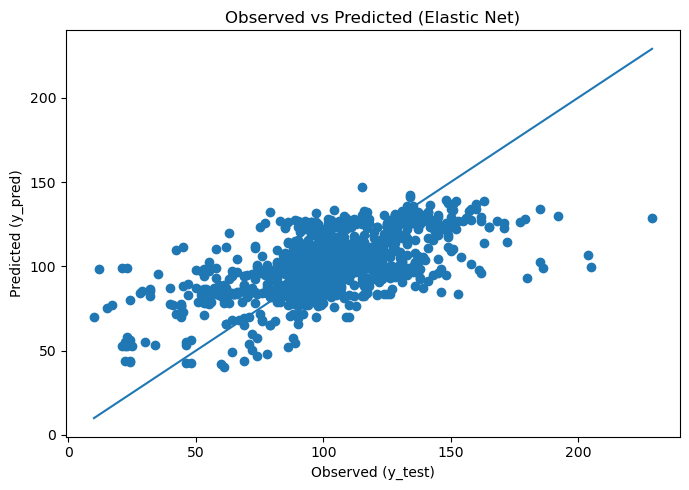


Saved plot to: figures/observed_vs_predicted_elasticnet.png


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# Refit best model on full training set (already split)
best_model = ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=20000)
best_model.fit(X_train, y_train)

# Predict on test
y_pred = best_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Elastic Net Test MSE:", mse)
print("Elastic Net Test R2 :", r2)

# Intercept
print("\nIntercept:", best_model.intercept_)

# Top 20 coefficients (largest by absolute value)
coef_series = pd.Series(best_model.coef_, index=X_train.columns)
top20 = coef_series.reindex(coef_series.abs().sort_values(ascending=False).head(20).index)
print("\nTop 20 coefficients (by absolute value):")
print(top20)

# Observed vs Predicted plot
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred)
plt.xlabel("Observed (y_test)")
plt.ylabel("Predicted (y_pred)")
plt.title("Observed vs Predicted (Elastic Net)")
# diagonal reference line
min_v = min(y_test.min(), y_pred.min())
max_v = max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v])
plt.tight_layout()

# Save figure
plt.savefig("figures/observed_vs_predicted_elasticnet.png", dpi=300)
plt.show()
print("\nSaved plot to: figures/observed_vs_predicted_elasticnet.png")


In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# We will build a SIMPLE model only for writing the regression equation:
# X = release_year + rating (categorical)
# y = duration_minutes

# Use your already prepared movies dataframe if you have it.
# If not, re-create quickly from df:
movies = df[df["type"] == "Movie"].copy()

# Convert duration to numeric minutes
movies["duration_minutes"] = movies["duration"].str.replace(" min", "", regex=False)
movies["duration_minutes"] = pd.to_numeric(movies["duration_minutes"], errors="coerce")

# Keep only needed columns
simple = movies[["release_year", "rating", "duration_minutes"]].dropna()

# Fill missing rating if any (safe)
simple["rating"] = simple["rating"].fillna("Unknown")

X = simple[["release_year", "rating"]]
y = simple["duration_minutes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocess = ColumnTransformer(
    transformers=[
        ("rating_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["rating"]),
    ],
    remainder="passthrough"  # keeps release_year as numeric
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("lr", LinearRegression())
])

model.fit(X_train, y_train)
preds = model.predict(X_test)

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Simple Linear Regression (release_year + rating)")
print("Test MSE:", mse)
print("Test R2 :", r2)

# Extract coefficients + feature names
feature_names = model.named_steps["prep"].get_feature_names_out()
coefs = model.named_steps["lr"].coef_
intercept = model.named_steps["lr"].intercept_

coef_table = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_table["abs"] = coef_table["coef"].abs()
coef_table = coef_table.sort_values("abs", ascending=False)

print("\nIntercept:", intercept)
print("\nTop 15 coefficients:")
print(coef_table.head(15)[["feature", "coef"]])


Simple Linear Regression (release_year + rating)
Test MSE: 577.5619748086906
Test R2 : 0.19294988826340376

Intercept: 1078.0580475184804

Top 15 coefficients:
                        feature       coef
1      rating_ohe__rating_NC-17  84.380848
10      rating_ohe__rating_TV-Y -44.978726
11     rating_ohe__rating_TV-Y7 -28.924766
12  rating_ohe__rating_TV-Y7-FV -26.243057
6      rating_ohe__rating_TV-14  14.347778
7       rating_ohe__rating_TV-G -12.622732
0          rating_ohe__rating_G -12.342693
4      rating_ohe__rating_PG-13  10.983064
5          rating_ohe__rating_R   9.689141
13        rating_ohe__rating_UR   4.044204
8      rating_ohe__rating_TV-MA   1.813287
9      rating_ohe__rating_TV-PG  -0.933487
3         rating_ohe__rating_PG   0.498622
14      remainder__release_year  -0.488047
2         rating_ohe__rating_NR   0.288514


In [11]:
get the release_year coefficient and intercept

SyntaxError: invalid syntax (1702107141.py, line 1)

In [12]:
import pandas as pd

coef_series = pd.Series(best_model.coef_, index=X_train.columns)

print("Intercept =", best_model.intercept_)
print("release_year coefficient =", coef_series["release_year"])

ValueError: Length of values (666) does not match length of index (2)

In [13]:
# STEP 1: Find the trained Elastic Net model object (best model) and print intercept + release_year coef

# If you already have these variables in your notebook, keep them:
# best_model_name, best_model_fit, best_model, best_pipeline, etc.

# Try the most common variable names (safe checks)
candidates = ["best_model", "best_pipeline", "elastic_net", "elasticnet", "model", "best_estimator", "final_model"]

found = []
for name in candidates:
    if name in globals():
        found.append(name)

print("Found model variables:", found)


Found model variables: ['best_model', 'model']


In [14]:
import pandas as pd
from sklearn.linear_model import ElasticNet

# 1) Split AGAIN from the encoded matrix (this guarantees matching columns)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# 2) Fit ElasticNet again
best_model = ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=20000)
best_model.fit(X_train, y_train)

# 3) Create coefficient series using the correct 666 column names
coef_series = pd.Series(best_model.coef_, index=X_encoded.columns)

print("Intercept =", best_model.intercept_)
print("release_year coefficient =", coef_series["release_year"])


ValueError: Found input variables with inconsistent numbers of samples: [6128, 6126]

In [15]:
import pandas as pd

# Rebuild X and y from your cleaned ML dataframe "data"
X = data[["release_year", "rating", "country"]].copy()
y = data["duration_minutes"].copy()

# One-hot encode again (same as before)
X_encoded = pd.get_dummies(X, columns=["rating", "country"], drop_first=True)

print("X_encoded shape:", X_encoded.shape)
print("y shape:", y.shape)
print("First 5 columns:", X_encoded.columns[:5].tolist())
print("release_year in columns?", "release_year" in X_encoded.columns)

X_encoded shape: (6128, 666)
y shape: (6128,)
First 5 columns: ['release_year', 'rating_NC-17', 'rating_NR', 'rating_PG', 'rating_PG-13']
release_year in columns? True


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
import pandas as pd

# split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# fit best model
best_model = ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=20000)
best_model.fit(X_train, y_train)

# coefficients
coef_series = pd.Series(best_model.coef_, index=X_encoded.columns)

print("Intercept =", best_model.intercept_)
print("release_year coefficient =", coef_series["release_year"])


Intercept = 995.0010963476923
release_year coefficient = -0.44818080771325075


In [17]:
sample5 = data.sample(5, random_state=7)   # random 5 rows
sample5

,release_year,rating,country,duration_minutes
4258,2018,TV-14,Unknown,73.0
7482,2016,R,"United States, Spain",84.0
3124,2018,TV-MA,Bangladesh,136.0
5819,2016,TV-MA,United States,73.0
792,2010,PG,United States,90.0


In [18]:
# Make sure coef_series exists (it should from earlier)
# coef_series = pd.Series(best_model.coef_, index=X_encoded.columns)

for i, row in sample5.iterrows():
    ry = row["release_year"]
    rt = row["rating"]
    ct = row["country"]

    rating_col = "rating_" + str(rt)
    country_col = "country_" + str(ct)

    rating_coef = coef_series[rating_col] if rating_col in coef_series.index else 0
    country_coef = coef_series[country_col] if country_col in coef_series.index else 0

    print("----")
    print("release_year:", ry)
    print("rating:", rt, "| rating_coef:", rating_coef)
    print("country:", ct, "| country_coef:", country_coef)
    print("observed duration:", row["duration_minutes"])


----
release_year: 2018
rating: TV-14 | rating_coef: 7.82571770081285
country: Unknown | country_coef: -1.3637012178235113
observed duration: 73.0
----
release_year: 2016
rating: R | rating_coef: 20.918601887962605
country: United States, Spain | country_coef: -9.321283787095092
observed duration: 84.0
----
release_year: 2018
rating: TV-MA | rating_coef: 4.796204804800225
country: Bangladesh | country_coef: 8.990314996960462
observed duration: 136.0
----
release_year: 2016
rating: TV-MA | rating_coef: 4.796204804800225
country: United States | country_coef: -11.56994098376423
observed duration: 73.0
----
release_year: 2010
rating: PG | rating_coef: 11.092445707203932
country: United States | country_coef: -11.56994098376423
observed duration: 90.0


In [19]:
import numpy as np
import pandas as pd

# categorical target based on a criterion (median split)
threshold = data["duration_minutes"].median()
y_class = (data["duration_minutes"] >= threshold).astype(int)

print("Threshold (median duration):", threshold)
print("Class counts:\n", y_class.value_counts())


Threshold (median duration): 98.0
Class counts:
 duration_minutes
1    3160
0    2968
Name: count, dtype: int64


In [20]:
from sklearn.model_selection import train_test_split

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_encoded, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print("Train X:", Xc_train.shape, "Train y:", yc_train.shape)
print("Test X :", Xc_test.shape,  "Test y :", yc_test.shape)


Train X: (4902, 666) Train y: (4902,)
Test X : (1226, 666) Test y : (1226,)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=3000),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7),
    "SVM (LinearSVC)": LinearSVC(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1),
    "Naive Bayes (Bernoulli)": BernoulliNB()
}

rows = []

for name, model in models.items():
    model.fit(Xc_train, yc_train)
    pred = model.predict(Xc_test)

    cm = confusion_matrix(yc_test, pred)
    tn, fp, fn, tp = cm.ravel()
    errors = fp + fn

    acc = accuracy_score(yc_test, pred)
    prec = precision_score(yc_test, pred)
    rec = recall_score(yc_test, pred)
    f1 = f1_score(yc_test, pred)

    rows.append({
        "Model": name,
        "Confusion Matrix": cm.tolist(),
        "Errors (FP+FN)": errors,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

results = pd.DataFrame(rows).sort_values(by="F1", ascending=False).reset_index(drop=True)
results


C:\Users\Maaz Ahmed\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Confusion Matrix,Errors (FP+FN),Accuracy,Precision,Recall,F1
0,Logistic Regression,"[[437, 157], [185, 447]]",342,0.721044,0.740066,0.707278,0.723301
1,Random Forest,"[[427, 167], [185, 447]]",352,0.712887,0.728013,0.707278,0.717496
2,SVM (LinearSVC),"[[446, 148], [205, 427]]",353,0.712072,0.742609,0.675633,0.707539
3,Decision Tree,"[[440, 154], [206, 426]]",360,0.706362,0.734483,0.674051,0.702970
4,K-Nearest Neighbors,"[[414, 180], [205, 427]]",385,0.685971,0.703460,0.675633,0.689266
5,Naive Bayes (Bernoulli),"[[441, 153], [232, 400]]",385,0.685971,0.723327,0.632911,0.675105


In [22]:
best_row = results.iloc[0]
print("Best model (by F1):", best_row["Model"])
print("Accuracy:", best_row["Accuracy"])
print("Precision:", best_row["Precision"])
print("Recall:", best_row["Recall"])
print("F1:", best_row["F1"])
print("Confusion Matrix:", best_row["Confusion Matrix"])

Best model (by F1): Logistic Regression
Accuracy: 0.7210440456769984
Precision: 0.7400662251655629
Recall: 0.7072784810126582
F1: 0.7233009708737864
Confusion Matrix: [[437, 157], [185, 447]]


In [23]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_rows = []
for name, model in models.items():
    scores = cross_val_score(model, X_encoded, y_class, cv=cv, scoring="accuracy")
    cv_rows.append({
        "Model": name,
        "CV Mean Accuracy": scores.mean(),
        "CV Std": scores.std()
    })

cv_results = pd.DataFrame(cv_rows).sort_values(by="CV Mean Accuracy", ascending=False).reset_index(drop=True)
cv_results


C:\Users\Maaz Ahmed\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Maaz Ahmed\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


,Model,CV Mean Accuracy,CV Std
0,Logistic Regression,0.713770,0.013609
1,SVM (LinearSVC),0.710997,0.009923
2,Random Forest,0.709040,0.007229
3,Decision Tree,0.702350,0.004896
4,K-Nearest Neighbors,0.689947,0.003209
5,Naive Bayes (Bernoulli),0.675427,0.023860


In [24]:
import numpy as np

print("best_model type:", type(best_model))

# If best_model is a Pipeline, this will work
try:
    steps = best_model.named_steps
    print("Pipeline steps:", list(steps.keys()))
except Exception as e:
    print("Not a Pipeline (or no named_steps):", e)

# Try to locate preprocessor + regressor inside the pipeline
preprocess = None
reg = None

if hasattr(best_model, "named_steps"):
    # common names
    for k in ["preprocess", "preprocessor", "prep", "ct"]:
        if k in best_model.named_steps:
            preprocess = best_model.named_steps[k]
            break

    # last step is usually the regressor
    last_key = list(best_model.named_steps.keys())[-1]
    reg = best_model.named_steps[last_key]

print("\nRegressor type:", type(reg))

# Feature names (after one-hot)
feature_names = None
if preprocess is not None and hasattr(preprocess, "get_feature_names_out"):
    feature_names = preprocess.get_feature_names_out()
    print("Total features:", len(feature_names))
else:
    print("Could not get feature names from preprocessor.")

# Intercept + release_year coefficient
if reg is not None and hasattr(reg, "intercept_") and hasattr(reg, "coef_") and feature_names is not None:
    intercept = float(reg.intercept_)
    coef = reg.coef_

    # Try both common feature name styles
    candidates = [
        "remainder__release_year",
        "num__release_year",
        "release_year",
        "remainder__release_year "
    ]

    rel_idx = None
    for c in candidates:
        matches = np.where(feature_names == c)[0]
        if len(matches) > 0:
            rel_idx = int(matches[0])
            rel_name = c
            break

    print("\nINTERCEPT =", intercept)
    if rel_idx is not None:
        print("release_year feature name =", rel_name)
        print("release_year COEF =", float(coef[rel_idx]))
    else:
        # fallback: search contains "release_year"
        hits = [i for i,n in enumerate(feature_names) if "release_year" in n]
        print("release_year not found exactly. Matches:", [feature_names[i] for i in hits[:10]])
else:
    print("Intercept/coef not available in the expected way.")


best_model type: <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
Not a Pipeline (or no named_steps): 'ElasticNet' object has no attribute 'named_steps'

Regressor type: <class 'NoneType'>
Could not get feature names from preprocessor.
Intercept/coef not available in the expected way.


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
import pandas as pd

# 1) split
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_encoded, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# 2) models
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7),
    "Naive Bayes": BernoulliNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "SVM (LinearSVC)": LinearSVC()
}

rows = []

# 3) evaluate
for name, model in models.items():
    model.fit(Xc_train, yc_train)
    pred = model.predict(Xc_test)

    cm = confusion_matrix(yc_test, pred)
    tn, fp, fn, tp = cm.ravel()
    errors = fp + fn

    rows.append({
        "Model": name,
        "Confusion Matrix": cm.tolist(),
        "Errors (FP+FN)": errors,
        "Accuracy": accuracy_score(yc_test, pred),
        "Precision": precision_score(yc_test, pred),
        "Recall": recall_score(yc_test, pred),
        "F1": f1_score(yc_test, pred)
    })

results = pd.DataFrame(rows).sort_values(by="F1", ascending=False).reset_index(drop=True)
results


,Model,Confusion Matrix,Errors (FP+FN),Accuracy,Precision,Recall,F1
0,Logistic Regression,"[[433, 161], [183, 449]]",344,0.719413,0.736066,0.710443,0.723027
1,Random Forest,"[[427, 167], [186, 446]]",353,0.712072,0.727569,0.705696,0.716466
2,SVM (LinearSVC),"[[446, 148], [205, 427]]",353,0.712072,0.742609,0.675633,0.707539
3,Decision Tree,"[[440, 154], [206, 426]]",360,0.706362,0.734483,0.674051,0.702970
4,K-Nearest Neighbors,"[[414, 180], [205, 427]]",385,0.685971,0.703460,0.675633,0.689266
5,Naive Bayes,"[[441, 153], [232, 400]]",385,0.685971,0.723327,0.632911,0.675105


In [26]:
y_class.value_counts()

duration_minutes
1    3160
0    2968
Name: count, dtype: int64

In [27]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Choose numeric features for clustering
cluster_df = data[["release_year", "duration_minutes"]].copy()

# Scale features (important for K-Means)
scaler = StandardScaler()
X_cluster = scaler.fit_transform(cluster_df)

print("Clustering features used:", cluster_df.columns.tolist())
print("X_cluster shape:", X_cluster.shape)
cluster_df.head()


Clustering features used: ['release_year', 'duration_minutes']
X_cluster shape: (6128, 2)


,release_year,duration_minutes
0,2020,90.0
6,2021,91.0
7,1993,125.0
9,2021,104.0
12,2021,127.0


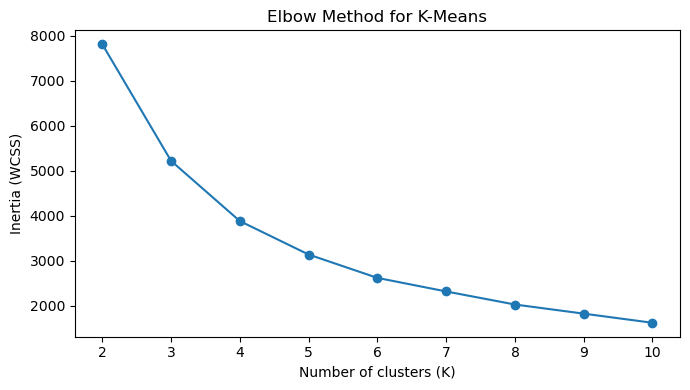

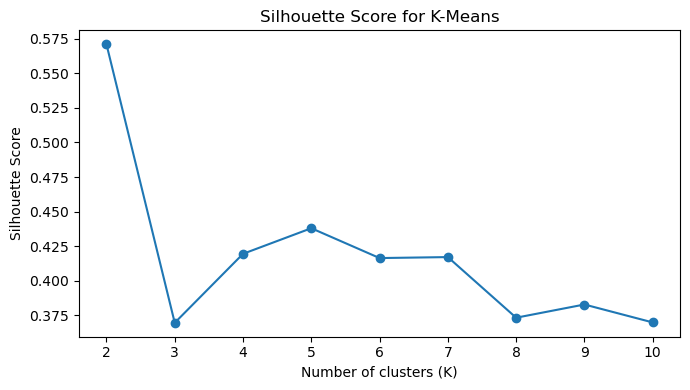

Best K by Silhouette: 2
    K      Inertia  Silhouette
0   2  7807.631384    0.571088
1   3  5219.089220    0.369490
2   4  3882.904419    0.419413
3   5  3140.020586    0.437939
4   6  2621.822933    0.416341
5   7  2320.404278    0.417047
6   8  2030.538373    0.373169
7   9  1828.096095    0.382729
8  10  1624.845465    0.369768


In [28]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_cluster, labels))

# Elbow plot
plt.figure(figsize=(7,4))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for K-Means")
plt.tight_layout()
plt.show()

# Silhouette plot
plt.figure(figsize=(7,4))
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for K-Means")
plt.tight_layout()
plt.show()

# Print best K by silhouette
best_k = list(K_range)[sil_scores.index(max(sil_scores))]
print("Best K by Silhouette:", best_k)
print(pd.DataFrame({"K": list(K_range), "Inertia": inertias, "Silhouette": sil_scores}))


cluster
0    5411
1     717
Name: count, dtype: int64


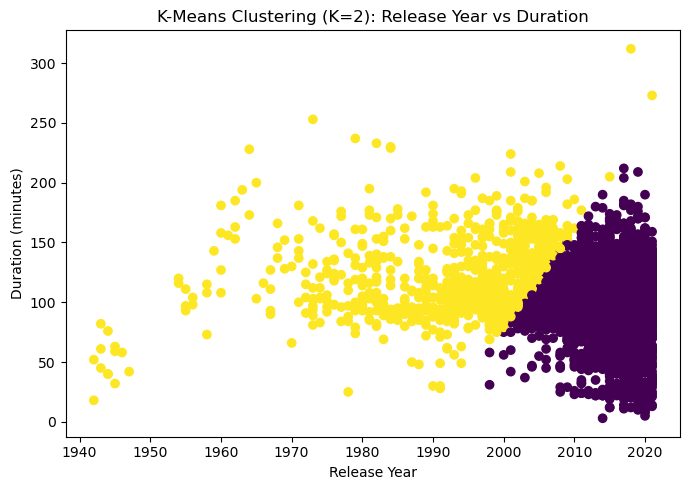

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Fit KMeans with the optimal K
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster)

# Add cluster labels to your original data
cluster_plot_df = cluster_df.copy()
cluster_plot_df["cluster"] = clusters

print(cluster_plot_df["cluster"].value_counts())

# Plot clusters (release_year vs duration_minutes)
plt.figure(figsize=(7,5))
plt.scatter(cluster_plot_df["release_year"], cluster_plot_df["duration_minutes"], c=cluster_plot_df["cluster"])
plt.xlabel("Release Year")
plt.ylabel("Duration (minutes)")
plt.title("K-Means Clustering (K=2): Release Year vs Duration")
plt.tight_layout()
plt.show()

In [30]:
cluster_plot_df.groupby("cluster")[["release_year","duration_minutes"]].agg(["count","mean","median","min","max"])

release_year                                  duration_minutes  \
               count         mean  median   min   max            count   
cluster                                                                  
0               5411  2015.942709  2017.0  1998  2021             5411   
1                717  1991.827057  1996.0  1942  2021              717   

                                         
               mean median   min    max  
cluster                                  
0         96.581593   97.0   3.0  212.0  
1        122.184100  117.0  18.0  312.0

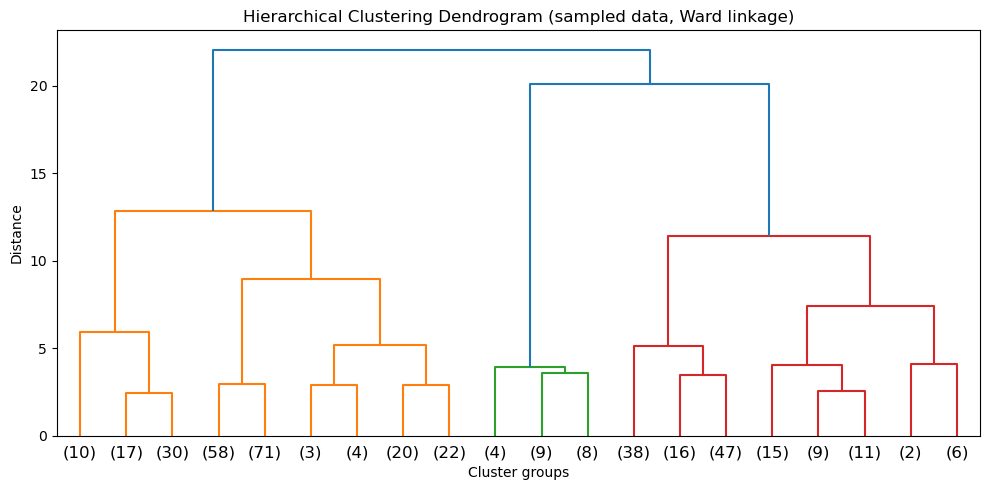

In [31]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# Use same scaled data: X_cluster (6128,2)
# Dendrogram for all 6128 points is too heavy, so we sample (allowed for visualization)
sample_for_dendo = cluster_df.sample(400, random_state=42)
X_dendo = scaler.fit_transform(sample_for_dendo)

Z = linkage(X_dendo, method="ward")

plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode="lastp", p=20)
plt.title("Hierarchical Clustering Dendrogram (sampled data, Ward linkage)")
plt.xlabel("Cluster groups")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


cluster_h
0    5430
1     698
Name: count, dtype: int64


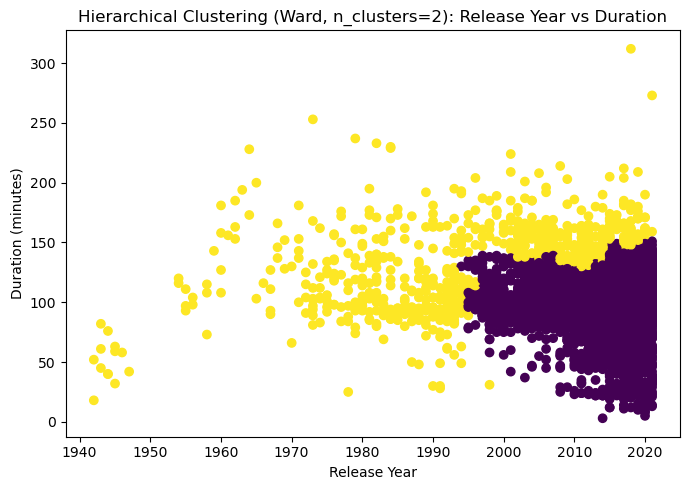

In [32]:
from sklearn.cluster import AgglomerativeClustering

# Choose number of clusters (same as K-Means = 2 for fair comparison)
agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
h_labels = agg.fit_predict(X_cluster)

cluster_h_df = cluster_df.copy()
cluster_h_df["cluster_h"] = h_labels

print(cluster_h_df["cluster_h"].value_counts())

plt.figure(figsize=(7,5))
plt.scatter(cluster_h_df["release_year"], cluster_h_df["duration_minutes"], c=cluster_h_df["cluster_h"])
plt.xlabel("Release Year")
plt.ylabel("Duration (minutes)")
plt.title("Hierarchical Clustering (Ward, n_clusters=2): Release Year vs Duration")
plt.tight_layout()
plt.show()
